<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/sherifmost/DeepLearning/blob/master/Labs/lab3/Lab3.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
</table>

# Assignment 2: Convolutional Neural Network Use Cases

![Simple CNN](https://github.com/sherifmost/DeepLearning/blob/master/Labs/lab3/Cover.png?raw=1)

## 2.1 Problem Statement

In this assignment you will build several CNN models that check if a person is happy or not. You will use custom made CNN, and CNN use cases either pretrained or not, also you will apply layers freezing on pretrained CNNs and study all those modifications effect on the accuracy.

**IMPORTANT NOTE:** You have to change runtime type on Google Colab to GPU since the CNN models used require much computation resources and it will run very slowly on CPU (Default runtime type)

Click on "Runtime" => "Change runtime type" => make sure that GPU is selected in the "Hardware accelerator"

## 2.2 Problem Details

### 2.2.1 Packages & Utility Methods

Make sure you check the imported modules as they can help you later on

In [1]:
import tensorflow as tf
import numpy as np
# you can use this library for resizing the images if you want
import cv2

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras import applications
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')

from IPython.display import SVG
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pydot
import h5py
import random
import requests

%matplotlib inline

In [2]:
def download_file(file_url):
    file_r = requests.get(file_url, allow_redirects=True)
    open(file_url.rsplit('/', 1)[1], 'wb').write(file_r.content)

### 2.2.2 Dataset Loading

#### Define method to download & load dataset

In [3]:
def load_dataset():
    download_file("https://raw.githubusercontent.com/KhaledElTahan/DeepLearning/master/Labs/lab3/lab3_train.h5")
    download_file("https://raw.githubusercontent.com/KhaledElTahan/DeepLearning/master/Labs/lab3/lab3_test.h5")

    path_to_train = "lab3_train.h5"
    path_to_test = "lab3_test.h5"

    train_dataset = h5py.File(path_to_train, "r")
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File(path_to_test, "r")
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    # reshape y from (samples, ) to (1, samples)
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_x.shape[0]))

    # transpose y
    train_y = train_y.T
    test_y = test_y.T

    return train_x, train_y, test_x, test_y

#### Define method to make simple preprocessing on the dataset

In [4]:
def preprocess_data():
    train_x, train_y, test_x, test_y = load_dataset()

    # Normalize image vectors
    train_x = train_x/255.
    test_x = test_x/255.

    print ("number of training examples = " + str(train_x.shape[0]))
    print ("number of test examples = " + str(test_x.shape[0]))

    print ("X_train shape: " + str(train_x.shape))
    print ("Y_train shape: " + str(train_y.shape))
    print ("X_test shape: " + str(test_x.shape))
    print ("Y_test shape: " + str(test_y.shape))

    return train_x, train_y, test_x, test_y

#### Get the preprocessed Data

In [5]:
# Obtaining the training and testing data
train_x, train_y, test_x, test_y = preprocess_data()

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


### 2.2.3 Dataset Visualization

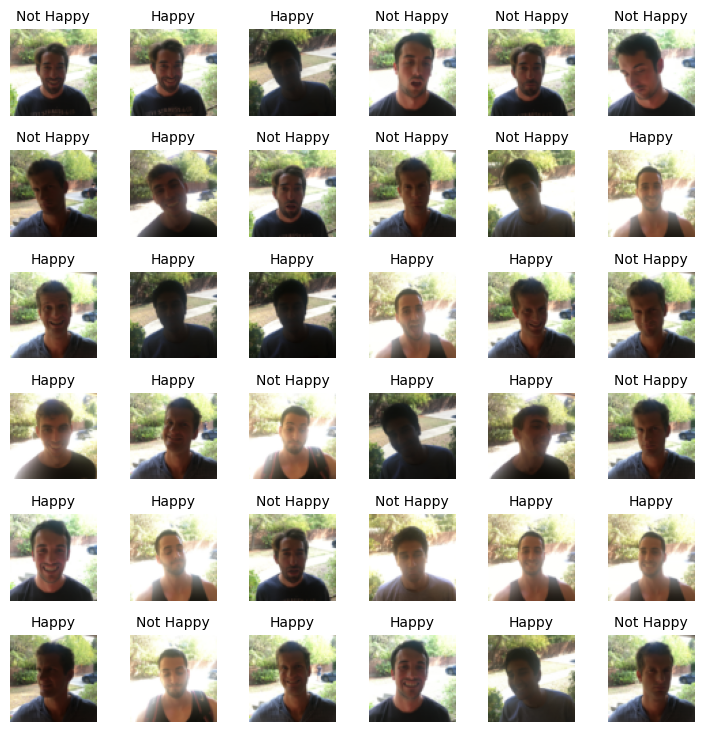

In [6]:
W_grid = 6
L_grid = 6

fig, axes = plt.subplots(L_grid, W_grid, figsize = (9,9))

axes = axes.ravel() # flaten the L_grid x W_grid matrix into L_grid * W_grid array

n_training = len(train_x) # get the length of the training dataset

for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    index = np.random.randint(0, n_training)
    axes[i].imshow(train_x[index])

    if train_y[index] == 1:
        axes[i].set_title("Happy", fontsize = 10)
    else:
        axes[i].set_title("Not Happy", fontsize = 10)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

### 2.2.4 Plot Utility Methods

The following code is used to plot accuracy and loss histories for each model experiment.

In [7]:
def plot(training_results, validation_results, results_type, model_name):
    fig = plt.figure(figsize=[8, 6])

    plt.plot(training_results, 'r', linewidth=3.0)
    plt.plot(validation_results, 'b', linewidth=3.0)
    plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(results_type, fontsize=16)
    plt.title(results_type + ' of ' + model_name, fontsize=16)


def plot_accuracy(history, model_name):
    plot(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', model_name)


def plot_loss(history, model_name):
    plot(history.history['loss'], history.history['val_loss'], 'Loss', model_name)

### 2.2.5 Custom CNN Model

**TODO**: Build a custom CNN model to solve the problem.

Model guidelines **(You need to follow them)**:

1. [Input](https://keras.io/api/layers/core_layers/input/) Layer.
2. [ZeroPadding2D](https://keras.io/api/layers/reshaping_layers/zero_padding2d/) Layer.
3. [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) Layer.
4. [BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/) Layer. You can read [this article](https://kharshit.github.io/blog/2018/12/28/why-batch-normalization) to learn more about BatchNormalization.
5. Relu [Activation](https://keras.io/api/layers/core_layers/activation/).
6. [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) Layer.
7. [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) Layer.
8. [Dense](https://keras.io/api/layers/core_layers/dense/) with Sigmoid activation (one perceptron).

**Note**: If you made the required model, you can make other custom CNN models **if you wish** to further improve the accuracy, but in other code cells however.

**Note**: the code provided below uses the tensorflow [functional API](https://www.tensorflow.org/guide/keras/functional) in building the model.

**Make sure to add the following to the report:**


*   The plot and accuracy achieved using the custom model at the end of the notebook (1.1 in the report)
*   **Optional**: The changes, plots, and accuracies achieved using other custom model variations (the optional question in part 1 in the report)



In [11]:
def CustomCNN(input_shape):
    """
    Implementation of the Custom CNN.
    Args:
        input_shape () shape of the images of the dataset
    Returns:
        model (Keras.Model): CNN Custom Model
        model_name (Str): The name of the model
    """
    ### START CODE HERE ###
    # Define the input layer
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    # Using 32 filters with 7x7 kernel size (you can adjust these)
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL with 2x2 pool size
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED (Dense)
    X = Flatten()(X)
    Y = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your tensorflow.keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=Y)
    ### END CODE HERE ###

    return model, "Custom CNN"

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 70, 70, 3)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 64, 64, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_407 (Activation)     │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool (MaxPooling2D)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,633 (147.00 KB)

 Trainable params: 37,569 (146.75 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.5481 - loss: 2.5822 - val_accuracy: 0.5467 - val_loss: 0.8940
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8252 - loss: 0.3997 - val_accuracy: 0.5467 - val_loss: 0.6400
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9237 - loss: 0.2001 - val_accuracy: 0.6400 - val_loss: 0.5424
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9370 - loss: 0.1697 - val_accuracy: 0.6333 - val_loss: 0.5689
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9584 - loss: 0.1237 - val_accuracy: 0.8133 - val_loss: 0.4392
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9709 - loss: 0.0938 - val_accuracy: 0.8933 - val_loss: 0.3805
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9845 - loss: 0.0657 - val_accuracy: 0.9200 - val_loss: 0.3468
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9763 - loss: 0.0729 - val_accuracy: 0.9133 - 

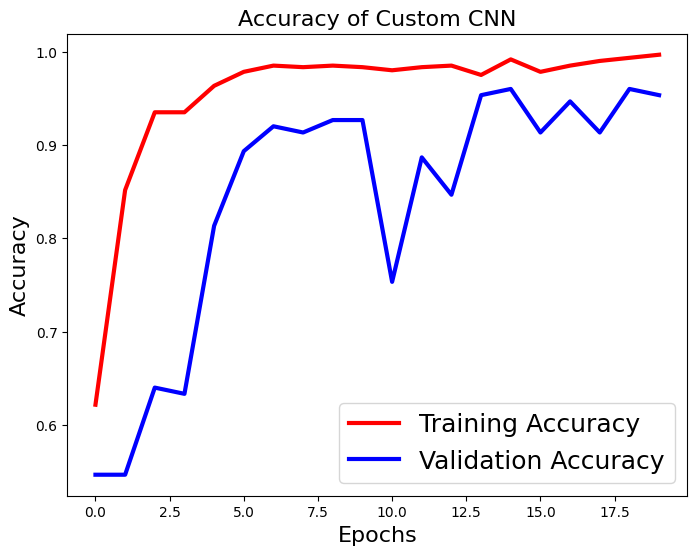

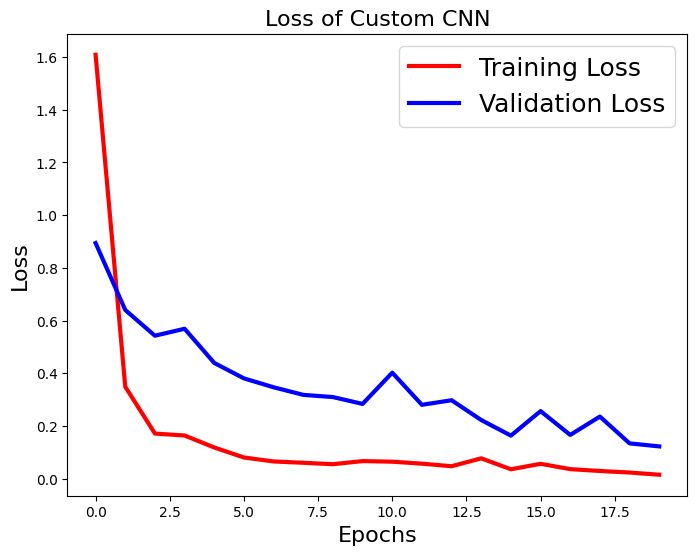

In [13]:
# Create the model
input_shape = (64, 64, 3)  # Changed from 224 to 64 to match your data
model, model_name = CustomCNN(input_shape)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

# Train the model
history = model.fit(
    train_x, train_y,  # Updated variable names
    batch_size=32,
    epochs=20,
    validation_data=(test_x, test_y)  # Updated variable names
)

# Plot results after training
plot_accuracy(history, model_name)
plot_loss(history, model_name)

### 2.2.6 CNN Use Case No.1: VGG

![VGG Architecture](https://github.com/sherifmost/DeepLearning/blob/master/Labs/lab3/vgg.png?raw=1)

**Note**: this ia a show case to help you do the same with other use cases.

**TODO**: Try different variations for VGG:

1. [VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)
2. [VGG19](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG19)

**Note**: *You will need to experiment all of them both pretrained (both with or without layers freezing) and also untrained, in the test section.*

**Make sure to add the following to the report:**


*   The plots and accuracy achieved using VGG16 untrained, pre-trained, and pre-trained with layer freezing with different number of frozen layers (from 2.1 till 2.5 in the report)
*   The plots and accuracy achieved using VGG19 untrained, pre-trained, and pre-trained with layer freezing with different number of frozen layers (from 2.6 till 2.10 in the report)



In [ ]:
def VGG(pretrained = True, input_shape = (64, 64, 3), model_name = "VGG16"):
    """
    Returns VGG Keras Model
    Args:
        pretrained (Bool): Whether get a pretrained model or not
        input_shape (Tuple): To create the input layer, should match the image resolution
        model_name (str): String to capture the model name
    Examples:
        VGG(True) -> Model, "Pretrained VGG16"
    """
    if(pretrained):
        model_name = "Pretrained " + model_name
        base_model = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')
    else:
        model_name = "Untrained " + model_name
        base_model = applications.vgg16.VGG16(weights=None, include_top=False, input_shape=input_shape, pooling='none')

    return base_model, model_name


2.10) Training VGG19 Pre-trained with 16 layers frozen...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 451ms/step - accuracy: 0.4833 - loss: 2.4390 - val_accuracy: 0.5600 - val_loss: 0.6903
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5259 - loss: 0.9093 - val_accuracy: 0.5600 - val_loss: 0.6913
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4843 - loss: 0.7981 - val_accuracy: 0.5600 - val_loss: 0.6926
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5074 - loss: 0.6932 - val_accuracy: 0.5600 - val_loss: 0.6913
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5072 - loss: 0.6935 - val_accuracy: 0.5600 - val_loss: 0.6919
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4989 - loss: 0.6935 - val_accuracy: 0.5600 - val_loss: 0.6931
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5088 - loss: 0.6933 - val_accuracy: 0.5600 - val_loss: 0.6930

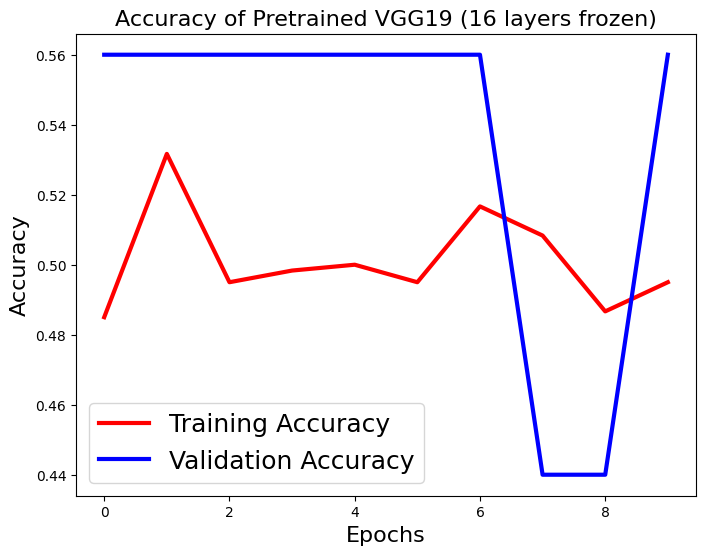

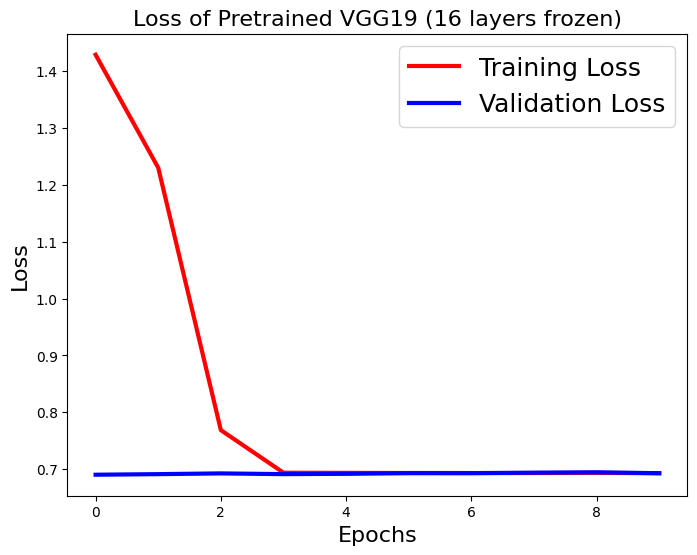

In [15]:
from tensorflow.keras import applications, layers, models

def VGG(pretrained=True, input_shape=(64, 64, 3), model_name="VGG16", freeze_layers=0):
    """
    Returns VGG Keras Model with optional layer freezing
    Args:
        pretrained (Bool): Whether get a pretrained model or not
        input_shape (Tuple): To create the input layer, should match the image resolution
        model_name (str): String to capture the model name ("VGG16" or "VGG19")
        freeze_layers (int): Number of layers to freeze from the beginning (0 = no freezing)
    Examples:
        VGG(True, freeze_layers=5) -> Model, "Pretrained VGG16 (5 layers frozen)"
    """
    # Select the appropriate VGG model
    if "VGG19" in model_name.upper():
        VGG_Model = applications.vgg19.VGG19
    else:
        VGG_Model = applications.vgg16.VGG16

    # Load base model
    if pretrained:
        base_model = VGG_Model(weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')
        model_label = f"Pretrained {model_name}"
    else:
        base_model = VGG_Model(weights=None, include_top=False, input_shape=input_shape, pooling='none')
        model_label = f"Untrained {model_name}"

    # Freeze layers if specified
    if freeze_layers > 0:
        for layer in base_model.layers[:freeze_layers]:
            layer.trainable = False
        model_label += f" ({freeze_layers} layers frozen)"

    # Add classification head
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1000, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    return model, model_label


# # ==================== VGG16 EXPERIMENTS ====================

# print("=" * 60)
# print("VGG16 EXPERIMENTS")
# print("=" * 60)

# # 2.1) VGG16 Untrained
# print("\n2.1) Training VGG16 Untrained...")
# model_21, name_21 = VGG(pretrained=False, input_shape=(64, 64, 3), model_name="VGG16")
# model_21.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_21 = model_21.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_21, test_acc_21 = model_21.evaluate(test_x, test_y)
# print(f"{name_21} - Test Accuracy: {test_acc_21:.4f}")
# plot_accuracy(history_21, name_21)
# plot_loss(history_21, name_21)

# # 2.2) VGG16 Pre-trained
# print("\n2.2) Training VGG16 Pre-trained...")
# model_22, name_22 = VGG(pretrained=True, input_shape=(64, 64, 3), model_name="VGG16")
# model_22.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_22 = model_22.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_22, test_acc_22 = model_22.evaluate(test_x, test_y)
# print(f"{name_22} - Test Accuracy: {test_acc_22:.4f}")
# plot_accuracy(history_22, name_22)
# plot_loss(history_22, name_22)

# # 2.3) VGG16 Pre-trained + freezing (5 layers)
# print("\n2.3) Training VGG16 Pre-trained with 5 layers frozen...")
# model_23, name_23 = VGG(pretrained=True, input_shape=(64, 64, 3), model_name="VGG16", freeze_layers=5)
# model_23.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_23 = model_23.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_23, test_acc_23 = model_23.evaluate(test_x, test_y)
# print(f"{name_23} - Test Accuracy: {test_acc_23:.4f}")
# plot_accuracy(history_23, name_23)
# plot_loss(history_23, name_23)

# # 2.4) VGG16 Pre-trained + freezing (10 layers)
# print("\n2.4) Training VGG16 Pre-trained with 10 layers frozen...")
# model_24, name_24 = VGG(pretrained=True, input_shape=(64, 64, 3), model_name="VGG16", freeze_layers=10)
# model_24.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_24 = model_24.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_24, test_acc_24 = model_24.evaluate(test_x, test_y)
# print(f"{name_24} - Test Accuracy: {test_acc_24:.4f}")
# plot_accuracy(history_24, name_24)
# plot_loss(history_24, name_24)

# # 2.5) VGG16 Pre-trained + freezing (13 layers)
# print("\n2.5) Training VGG16 Pre-trained with 13 layers frozen...")
# model_25, name_25 = VGG(pretrained=True, input_shape=(64, 64, 3), model_name="VGG16", freeze_layers=13)
# model_25.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_25 = model_25.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_25, test_acc_25 = model_25.evaluate(test_x, test_y)
# print(f"{name_25} - Test Accuracy: {test_acc_25:.4f}")
# plot_accuracy(history_25, name_25)
# plot_loss(history_25, name_25)


# # ==================== VGG19 EXPERIMENTS ====================

# print("\n" + "=" * 60)
# print("VGG19 EXPERIMENTS")
# print("=" * 60)

# # 2.6) VGG19 Untrained
# print("\n2.6) Training VGG19 Untrained...")
# model_26, name_26 = VGG(pretrained=False, input_shape=(64, 64, 3), model_name="VGG19")
# model_26.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_26 = model_26.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_26, test_acc_26 = model_26.evaluate(test_x, test_y)
# print(f"{name_26} - Test Accuracy: {test_acc_26:.4f}")
# plot_accuracy(history_26, name_26)
# plot_loss(history_26, name_26)

# # 2.7) VGG19 Pre-trained
# print("\n2.7) Training VGG19 Pre-trained...")
# model_27, name_27 = VGG(pretrained=True, input_shape=(64, 64, 3), model_name="VGG19")
# model_27.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_27 = model_27.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_27, test_acc_27 = model_27.evaluate(test_x, test_y)
# print(f"{name_27} - Test Accuracy: {test_acc_27:.4f}")
# plot_accuracy(history_27, name_27)
# plot_loss(history_27, name_27)

# # 2.8) VGG19 Pre-trained + freezing (5 layers)
# print("\n2.8) Training VGG19 Pre-trained with 5 layers frozen...")
# model_28, name_28 = VGG(pretrained=True, input_shape=(64, 64, 3), model_name="VGG19", freeze_layers=5)
# model_28.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_28 = model_28.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_28, test_acc_28 = model_28.evaluate(test_x, test_y)
# print(f"{name_28} - Test Accuracy: {test_acc_28:.4f}")
# plot_accuracy(history_28, name_28)
# plot_loss(history_28, name_28)

# # 2.9) VGG19 Pre-trained + freezing (10 layers)
# print("\n2.9) Training VGG19 Pre-trained with 10 layers frozen...")
# model_29, name_29 = VGG(pretrained=True, input_shape=(64, 64, 3), model_name="VGG19", freeze_layers=10)
# model_29.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_29 = model_29.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_29, test_acc_29 = model_29.evaluate(test_x, test_y)
# print(f"{name_29} - Test Accuracy: {test_acc_29:.4f}")
# plot_accuracy(history_29, name_29)
# plot_loss(history_29, name_29)

# 2.10) VGG19 Pre-trained + freezing (16 layers)
print("\n2.10) Training VGG19 Pre-trained with 16 layers frozen...")
model_210, name_210 = VGG(pretrained=True, input_shape=(64, 64, 3), model_name="VGG19", freeze_layers=16)
model_210.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_210 = model_210.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
test_loss_210, test_acc_210 = model_210.evaluate(test_x, test_y)
print(f"{name_210} - Test Accuracy: {test_acc_210:.4f}")
plot_accuracy(history_210, name_210)
plot_loss(history_210, name_210)

### 2.2.7 CNN Use Case No.2: Residual Connections-based Networks

![VGG vs ResNet](https://github.com/sherifmost/DeepLearning/blob/master/Labs/lab3/VGG_vs_ResNet.png?raw=1)

**TODO**: Follow the same style for the above mentioned VGG and experiment the following Networks:

1. [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50)
2. [ResNet101](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet101)
3. [InceptionResNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_resnet_v2/InceptionResNetV2) this network builds on the inception network architecture and incorporates [residual connections](https://towardsdatascience.com/what-is-residual-connection-efb07cab0d55), you can read more about it [here](https://paperswithcode.com/method/inception-resnet-v2#:~:text=Inception%2DResNet%2Dv2%20is%20a,stage%20of%20the%20Inception%20architecture).

**Note 1**: *You will need to experiment all of them both pretrained (both with or without layers freezing) and also untrained, in the test section.*

**Note 2**: For very deep networks like **InceptionResNetV2**, the size of the input might get reduced too much and an error might be produced, **you need to fix this issue by either resizing the images (preferred) or by adding padding (not preferred)**.

To resize the image you *can* follow the following steps (*just some possible guidelines)*:

*   You can use [cv2.resize](https://www.geeksforgeeks.org/image-resizing-using-opencv-python/) or [tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize).
*   Make a function similar to preprocess_data() but instead resize the train and test images before returning them at the end
*   When you train the model that is causing the error, call the new function you made to obtain the training and testing data instead of calling the original preprocess_data() *(as was done at the beggining of the notebook)*



**Make sure to add the following to the report:**


*   The plots and accuracy achieved using ResNet50 untrained, pre-trained, and pre-trained with layer freezing with different number of frozen layers (from 3.1 till 3.5 in the report)
*   The plots and accuracy achieved using ResNet101 untrained, pre-trained, and pre-trained with layer freezing with different number of frozen layers (from 3.6 till 3.10 in the report)
*   The plots and accuracy achieved using InceptionResNetV2 untrained, pre-trained, and pre-trained with layer freezing with different number of frozen layers (from 3.11 till 3.15 in the report)



In [8]:
def preprocess_data_resized(train_x, train_y, test_x, test_y, target_size=(128, 128)):
    """
    Resize images to target size for deep networks
    Args:
        train_x, train_y: Training data
        test_x, test_y: Testing data
        target_size: Tuple (height, width) for resizing
    Returns:
        Resized train_x, train_y, test_x, test_y
    """
    # Resize training images
    train_x_resized = tf.image.resize(train_x, target_size).numpy()

    # Resize testing images
    test_x_resized = tf.image.resize(test_x, target_size).numpy()

    return train_x_resized, train_y, test_x_resized, test_y

In [9]:
from tensorflow.keras import applications, layers, models

def ResNet(pretrained=True, input_shape=(64, 64, 3), model_name="ResNet50", freeze_layers=0):
    """
    Returns ResNet-based Keras Model with optional layer freezing
    Args:
        pretrained (Bool): Whether get a pretrained model or not
        input_shape (Tuple): To create the input layer, should match the image resolution
        model_name (str): String to capture the model name ("ResNet50", "ResNet101", "InceptionResNetV2")
        freeze_layers (int): Number of layers to freeze from the beginning (0 = no freezing)
    Examples:
        ResNet(True, freeze_layers=10) -> Model, "Pretrained ResNet50 (10 layers frozen)"
    """
    # Select the appropriate model
    if "ResNet101" in model_name:
        ResNet_Model = applications.resnet.ResNet101
    elif "InceptionResNetV2" in model_name:
        ResNet_Model = applications.inception_resnet_v2.InceptionResNetV2
    else:  # Default to ResNet50
        ResNet_Model = applications.resnet.ResNet50

    # Load base model
    if pretrained:
        base_model = ResNet_Model(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')
        model_label = f"Pretrained {model_name}"
    else:
        base_model = ResNet_Model(weights=None, include_top=False, input_shape=input_shape, pooling='avg')
        model_label = f"Untrained {model_name}"

    # Freeze layers if specified
    if freeze_layers > 0:
        for layer in base_model.layers[:freeze_layers]:
            layer.trainable = False
        model_label += f" ({freeze_layers} layers frozen)"

    # Add classification head
    model = models.Sequential([
        base_model,
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    return model, model_label


InceptionResNetV2 EXPERIMENTS
Resizing images for InceptionResNetV2...

3.14) Training InceptionResNetV2 Pre-trained with 200 layers frozen...
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.7016 - loss: 0.7091 - val_accuracy: 0.5600 - val_loss: 20.9663
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step - accuracy: 0.9865 - loss: 0.0523 - val_accuracy: 0.4400 - val_loss: 4.4574
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9736 - loss: 0.0758 - val_accuracy: 0.8667 - val_loss: 0.3214
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.9795 - loss: 0.0486 - val_accuracy: 0.7467 - val_loss: 3.1485
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9940 - loss: 0.0366 - val_accuracy: 0.9200 - val_loss: 0.5096
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9986 - loss: 0.0057 - val_accuracy: 0.9867 - val_loss: 0.1145
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━

NameError: name 'name_31' is not defined

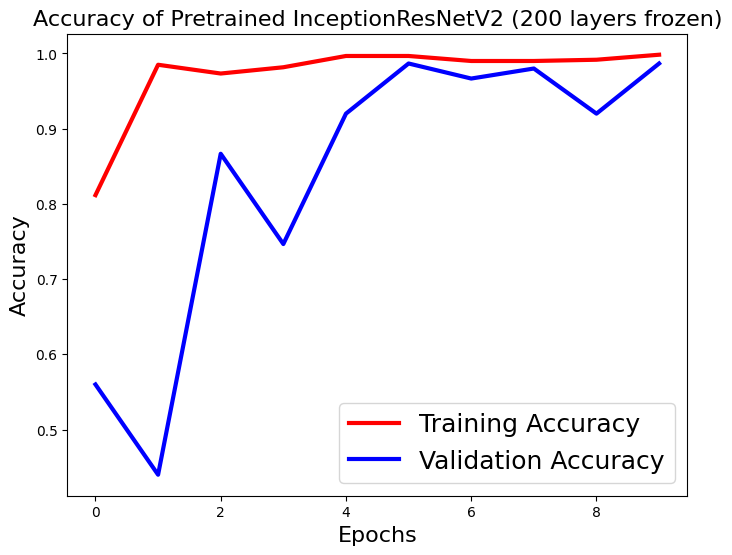

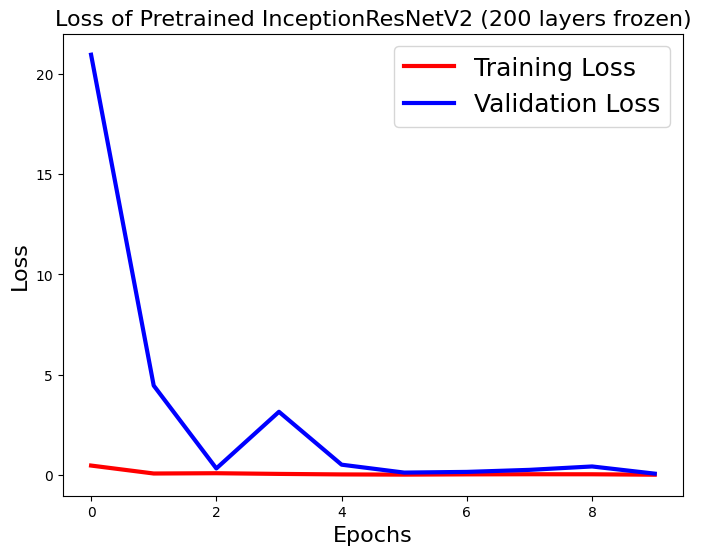

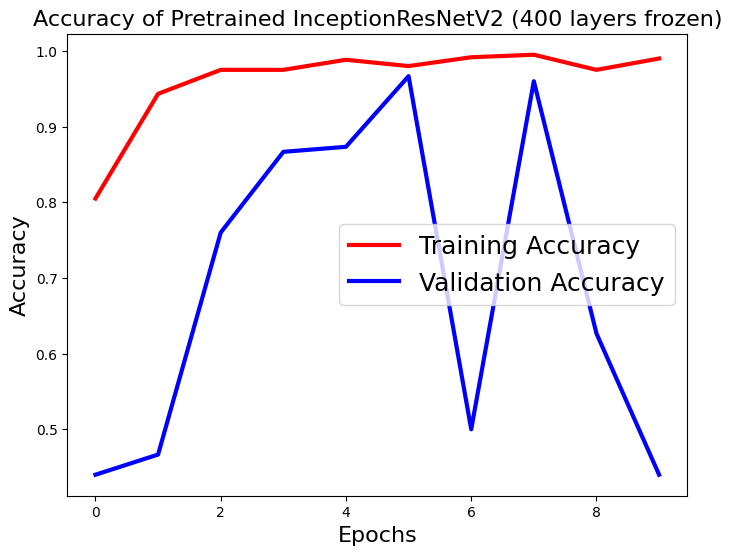

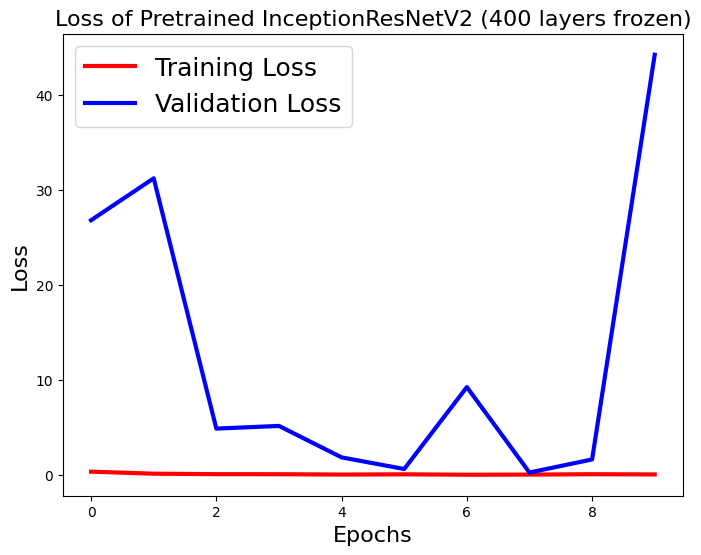

In [10]:
from tensorflow.keras import applications, layers, models
import tensorflow as tf
import numpy as np

# # ==================== ResNet50 EXPERIMENTS ====================

# print("=" * 60)
# print("ResNet50 EXPERIMENTS")
# print("=" * 60)

# # 3.1) ResNet50 Untrained
# print("\n3.1) Training ResNet50 Untrained...")
# model_31, name_31 = ResNet(pretrained=False, input_shape=(64, 64, 3), model_name="ResNet50")
# model_31.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_31 = model_31.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_31, test_acc_31 = model_31.evaluate(test_x, test_y)
# print(f"{name_31} - Test Accuracy: {test_acc_31:.4f}")
# plot_accuracy(history_31, name_31)
# plot_loss(history_31, name_31)

# # 3.2) ResNet50 Pre-trained
# print("\n3.2) Training ResNet50 Pre-trained...")
# model_32, name_32 = ResNet(pretrained=True, input_shape=(64, 64, 3), model_name="ResNet50")
# model_32.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_32 = model_32.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_32, test_acc_32 = model_32.evaluate(test_x, test_y)
# print(f"{name_32} - Test Accuracy: {test_acc_32:.4f}")
# plot_accuracy(history_32, name_32)
# plot_loss(history_32, name_32)

# # 3.3) ResNet50 Pre-trained + freezing (20 layers)
# print("\n3.3) Training ResNet50 Pre-trained with 20 layers frozen...")
# model_33, name_33 = ResNet(pretrained=True, input_shape=(64, 64, 3), model_name="ResNet50", freeze_layers=20)
# model_33.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_33 = model_33.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_33, test_acc_33 = model_33.evaluate(test_x, test_y)
# print(f"{name_33} - Test Accuracy: {test_acc_33:.4f}")
# plot_accuracy(history_33, name_33)
# plot_loss(history_33, name_33)

# # 3.4) ResNet50 Pre-trained + freezing (50 layers)
# print("\n3.4) Training ResNet50 Pre-trained with 50 layers frozen...")
# model_34, name_34 = ResNet(pretrained=True, input_shape=(64, 64, 3), model_name="ResNet50", freeze_layers=50)
# model_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_34 = model_34.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_34, test_acc_34 = model_34.evaluate(test_x, test_y)
# print(f"{name_34} - Test Accuracy: {test_acc_34:.4f}")
# plot_accuracy(history_34, name_34)
# plot_loss(history_34, name_34)

# # 3.5) ResNet50 Pre-trained + freezing (100 layers)
# print("\n3.5) Training ResNet50 Pre-trained with 100 layers frozen...")
# model_35, name_35 = ResNet(pretrained=True, input_shape=(64, 64, 3), model_name="ResNet50", freeze_layers=100)
# model_35.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_35 = model_35.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_35, test_acc_35 = model_35.evaluate(test_x, test_y)
# print(f"{name_35} - Test Accuracy: {test_acc_35:.4f}")
# plot_accuracy(history_35, name_35)
# plot_loss(history_35, name_35)


# # ==================== ResNet101 EXPERIMENTS ====================

# print("\n" + "=" * 60)
# print("ResNet101 EXPERIMENTS")
# print("=" * 60)

# # 3.6) ResNet101 Untrained
# print("\n3.6) Training ResNet101 Untrained...")
# model_36, name_36 = ResNet(pretrained=False, input_shape=(64, 64, 3), model_name="ResNet101")
# model_36.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_36 = model_36.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_36, test_acc_36 = model_36.evaluate(test_x, test_y)
# print(f"{name_36} - Test Accuracy: {test_acc_36:.4f}")
# plot_accuracy(history_36, name_36)
# plot_loss(history_36, name_36)

# # 3.7) ResNet101 Pre-trained
# print("\n3.7) Training ResNet101 Pre-trained...")
# model_37, name_37 = ResNet(pretrained=True, input_shape=(64, 64, 3), model_name="ResNet101")
# model_37.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_37 = model_37.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_37, test_acc_37 = model_37.evaluate(test_x, test_y)
# print(f"{name_37} - Test Accuracy: {test_acc_37:.4f}")
# plot_accuracy(history_37, name_37)
# plot_loss(history_37, name_37)

# # 3.8) ResNet101 Pre-trained + freezing (20 layers)
# print("\n3.8) Training ResNet101 Pre-trained with 20 layers frozen...")
# model_38, name_38 = ResNet(pretrained=True, input_shape=(64, 64, 3), model_name="ResNet101", freeze_layers=20)
# model_38.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_38 = model_38.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_38, test_acc_38 = model_38.evaluate(test_x, test_y)
# print(f"{name_38} - Test Accuracy: {test_acc_38:.4f}")
# plot_accuracy(history_38, name_38)
# plot_loss(history_38, name_38)

# # 3.9) ResNet101 Pre-trained + freezing (50 layers)
# print("\n3.9) Training ResNet101 Pre-trained with 50 layers frozen...")
# model_39, name_39 = ResNet(pretrained=True, input_shape=(64, 64, 3), model_name="ResNet101", freeze_layers=50)
# model_39.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_39 = model_39.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_39, test_acc_39 = model_39.evaluate(test_x, test_y)
# print(f"{name_39} - Test Accuracy: {test_acc_39:.4f}")
# plot_accuracy(history_39, name_39)
# plot_loss(history_39, name_39)

# # 3.10) ResNet101 Pre-trained + freezing (150 layers)
# print("\n3.10) Training ResNet101 Pre-trained with 150 layers frozen...")
# model_310, name_310 = ResNet(pretrained=True, input_shape=(64, 64, 3), model_name="ResNet101", freeze_layers=150)
# model_310.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_310 = model_310.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
# test_loss_310, test_acc_310 = model_310.evaluate(test_x, test_y)
# print(f"{name_310} - Test Accuracy: {test_acc_310:.4f}")
# plot_accuracy(history_310, name_310)
# plot_loss(history_310, name_310)


# ==================== InceptionResNetV2 EXPERIMENTS ====================
# Note: InceptionResNetV2 requires larger input size (minimum 75x75)

print("\n" + "=" * 60)
print("InceptionResNetV2 EXPERIMENTS")
print("=" * 60)

# Resize images for InceptionResNetV2
print("Resizing images for InceptionResNetV2...")
train_x_resized, train_y_resized, test_x_resized, test_y_resized = preprocess_data_resized(
    train_x, train_y, test_x, test_y, target_size=(128, 128)
)

# # 3.11) InceptionResNetV2 Untrained
# print("\n3.11) Training InceptionResNetV2 Untrained...")
# model_311, name_311 = ResNet(pretrained=False, input_shape=(128, 128, 3), model_name="InceptionResNetV2")
# model_311.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_311 = model_311.fit(train_x_resized, train_y_resized, batch_size=32, epochs=10, validation_data=(test_x_resized, test_y_resized))
# test_loss_311, test_acc_311 = model_311.evaluate(test_x_resized, test_y_resized)
# print(f"{name_311} - Test Accuracy: {test_acc_311:.4f}")
# plot_accuracy(history_311, name_311)
# plot_loss(history_311, name_311)

# # 3.12) InceptionResNetV2 Pre-trained
# print("\n3.12) Training InceptionResNetV2 Pre-trained...")
# model_312, name_312 = ResNet(pretrained=True, input_shape=(128, 128, 3), model_name="InceptionResNetV2")
# model_312.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_312 = model_312.fit(train_x_resized, train_y_resized, batch_size=32, epochs=10, validation_data=(test_x_resized, test_y_resized))
# test_loss_312, test_acc_312 = model_312.evaluate(test_x_resized, test_y_resized)
# print(f"{name_312} - Test Accuracy: {test_acc_312:.4f}")
# plot_accuracy(history_312, name_312)
# plot_loss(history_312, name_312)

# # 3.13) InceptionResNetV2 Pre-trained + freezing (50 layers)
# print("\n3.13) Training InceptionResNetV2 Pre-trained with 50 layers frozen...")
# model_313, name_313 = ResNet(pretrained=True, input_shape=(128, 128, 3), model_name="InceptionResNetV2", freeze_layers=50)
# model_313.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_313 = model_313.fit(train_x_resized, train_y_resized, batch_size=32, epochs=10, validation_data=(test_x_resized, test_y_resized))
# test_loss_313, test_acc_313 = model_313.evaluate(test_x_resized, test_y_resized)
# print(f"{name_313} - Test Accuracy: {test_acc_313:.4f}")
# plot_accuracy(history_313, name_313)
# plot_loss(history_313, name_313)

# 3.14) InceptionResNetV2 Pre-trained + freezing (200 layers)
print("\n3.14) Training InceptionResNetV2 Pre-trained with 200 layers frozen...")
model_314, name_314 = ResNet(pretrained=True, input_shape=(128, 128, 3), model_name="InceptionResNetV2", freeze_layers=200)
model_314.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_314 = model_314.fit(train_x_resized, train_y_resized, batch_size=32, epochs=10, validation_data=(test_x_resized, test_y_resized))
test_loss_314, test_acc_314 = model_314.evaluate(test_x_resized, test_y_resized)
print(f"{name_314} - Test Accuracy: {test_acc_314:.4f}")
plot_accuracy(history_314, name_314)
plot_loss(history_314, name_314)

# 3.15) InceptionResNetV2 Pre-trained + freezing (400 layers)
print("\n3.15) Training InceptionResNetV2 Pre-trained with 400 layers frozen...")
model_315, name_315 = ResNet(pretrained=True, input_shape=(128, 128, 3), model_name="InceptionResNetV2", freeze_layers=400)
model_315.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_315 = model_315.fit(train_x_resized, train_y_resized, batch_size=32, epochs=10, validation_data=(test_x_resized, test_y_resized))
test_loss_315, test_acc_315 = model_315.evaluate(test_x_resized, test_y_resized)
print(f"{name_315} - Test Accuracy: {test_acc_315:.4f}")
plot_accuracy(history_315, name_315)
plot_loss(history_315, name_315)


# ==================== SUMMARY OF RESNET EXPERIMENTS ====================

print("\n" + "=" * 60)
print("SUMMARY OF RESNET EXPERIMENTS")
print("=" * 60)

resnet_results = [
    (name_31, test_acc_31), (name_32, test_acc_32), (name_33, test_acc_33),
    (name_34, test_acc_34), (name_35, test_acc_35), (name_36, test_acc_36),
    (name_37, test_acc_37), (name_38, test_acc_38), (name_39, test_acc_39),
    (name_310, test_acc_310), (name_311, test_acc_311), (name_312, test_acc_312),
    (name_313, test_acc_313), (name_314, test_acc_314), (name_315, test_acc_315),
]

for i, (name, acc) in enumerate(resnet_results, start=1):
    print(f"3.{i}) {name}: {acc:.4f}")

### 2.2.8 CNN Use Case No.3: Your choice

**TODO**: Select one application other than VGG or ResNet from [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications) and implement it the same way you did with VGG & ResNet.

**Note**: *You will need to experiment it in both pretrained (both with or without layers freezing) and also untrained, in the test section.*

**Make sure to add the following to the report:**


*   The name of the chosen model, plots and accuracy achieved using this model untrained, pre-trained, and pre-trained with layer freezing with different number of frozen layers (from 4.1 till 4.5 in the report)


In [ ]:
def CNN_App(pretrained = True, input_shape = (64, 64, 3), model_name = 'Name your Chosen CNN APP Here'):
    """
    Returns A Custom CNN Application Keras Model
    Args:
        pretrained (Bool): Whether get a pretrained model or not
        input_shape (Tuple): To create the input layer, should match the image resolution
        model_name (str): String to capture the model name
    Examples:
        CNN_App(True, (64, 64, 3), "Xception") -> Model, "Pretrained Xception"
    """
    if(pretrained):
        model_name = "Pretrained " + model_name
        base_model = '''TODO: Define the pretrained model using keras.applications'''
    else:
        model_name = "Untrained " + model_name
        base_model = '''TODO: Define the untrained model using keras.applications'''

    return base_model, model_name

MobileNetV2 EXPERIMENTS

4.1) Training MobileNetV2 Untrained...
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.6105 - loss: 0.7463 - val_accuracy: 0.4400 - val_loss: 0.6935
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8899 - loss: 0.2692 - val_accuracy: 0.4400 - val_loss: 0.6937
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9637 - loss: 0.0928 - val_accuracy: 0.5600 - val_loss: 0.6919
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9797 - loss: 0.0720 - val_accuracy: 0.5600 - val_loss: 0.6918
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9860 - loss: 0.0537 - val_accuracy: 0.5600 - val_loss: 0.6912
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9502 - loss: 0.1084 - val_accuracy: 0.5600 - val_loss: 0.6913
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9974 - loss: 0.0221 - val_accuracy: 0.5600 - val_loss: 0.6893
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/st

/tmp/ipython-input-1440945521.py:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.mobilenet_v2.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7645 - loss: 0.5160 - val_accuracy: 0.4400 - val_loss: 9.9654
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9386 - loss: 0.2749 - val_accuracy: 0.4400 - val_loss: 12.3914
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9100 - loss: 0.3303 - val_accuracy: 0.4533 - val_loss: 6.6872
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9571 - loss: 0.1951 - val_accuracy: 0.5067 - val_loss: 9.6664
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9698 - loss: 0.0664 - val_accuracy: 0.4400 - val_loss: 14.9466
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9813 - loss: 0.0588 - val_accuracy: 0.5933 - val_loss: 11.7333
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9930 - loss: 0.0370 - val_accuracy: 0.5933 - val_loss: 6.6968
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accurac

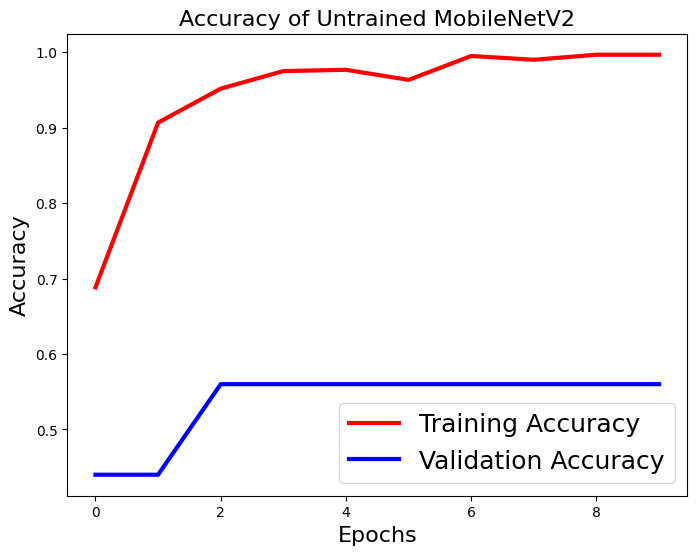

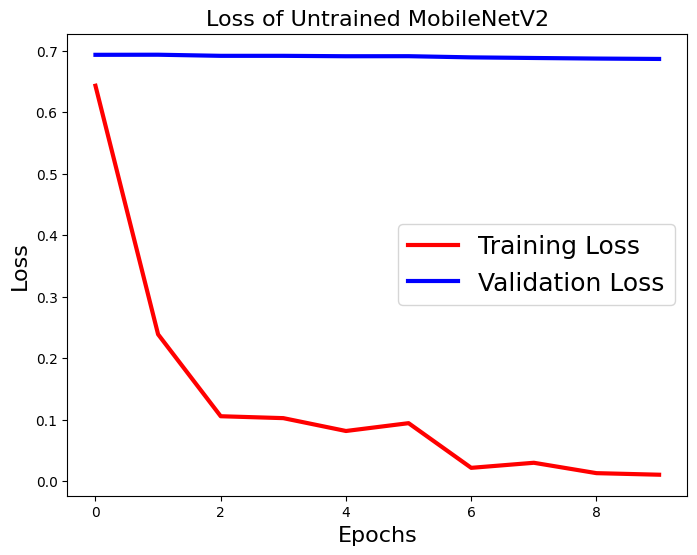

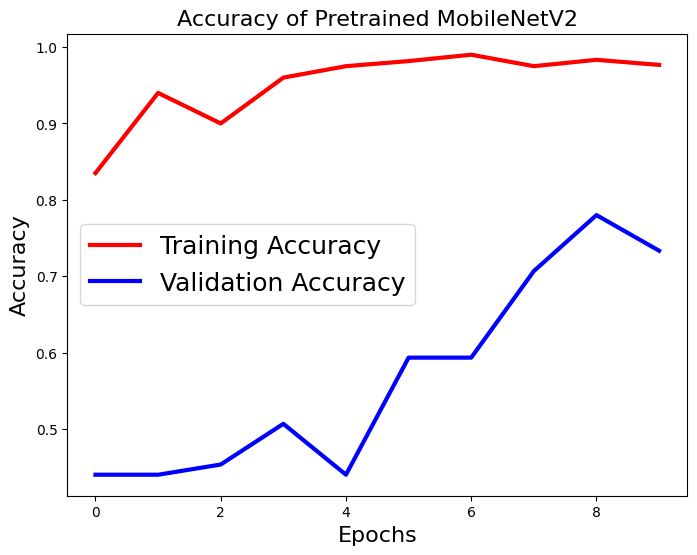

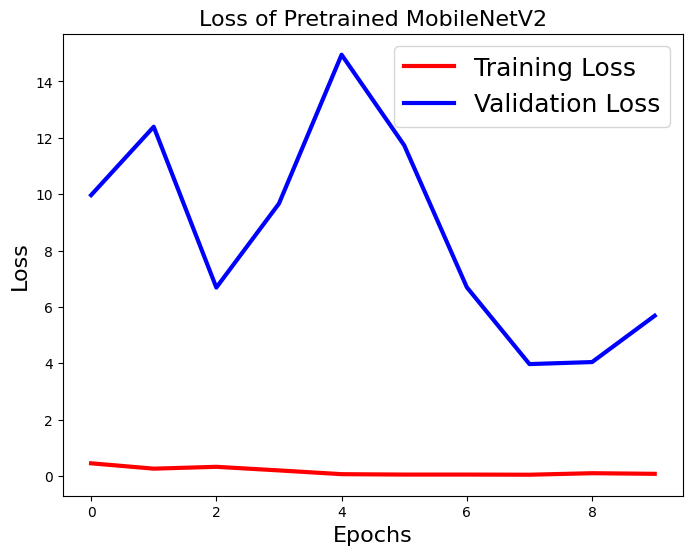

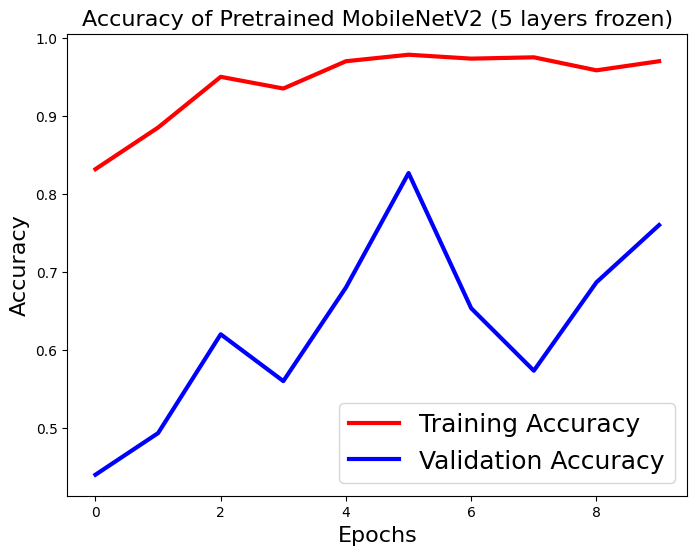

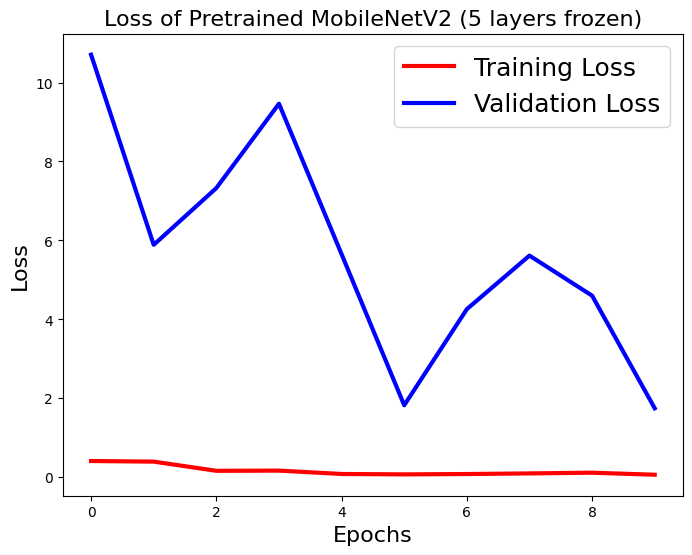

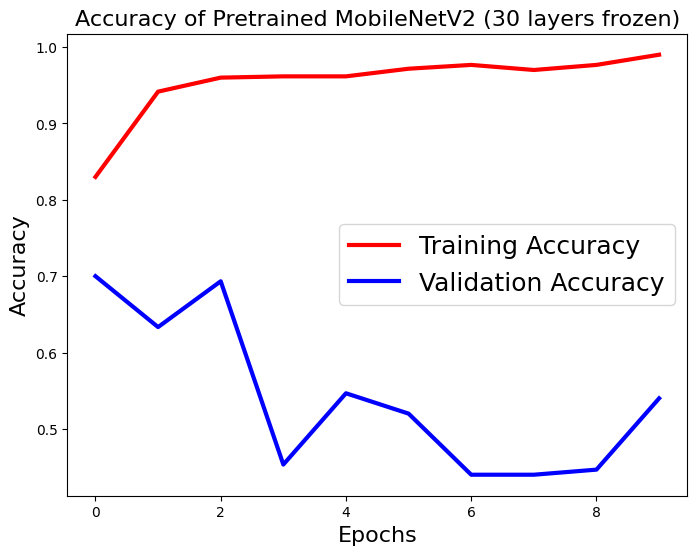

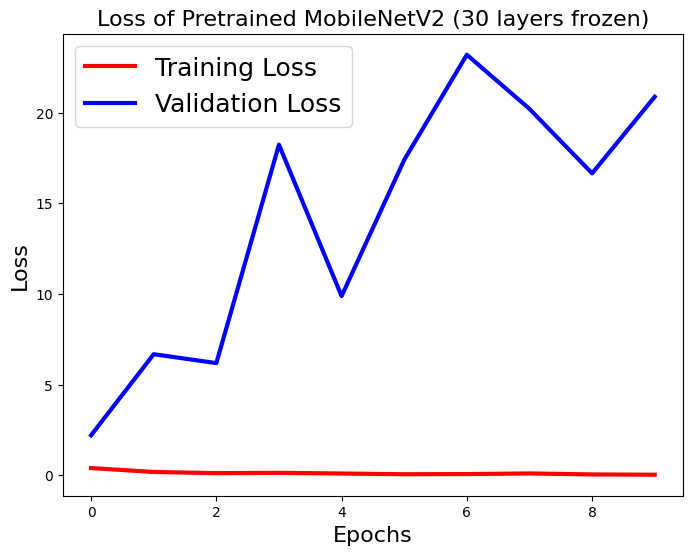

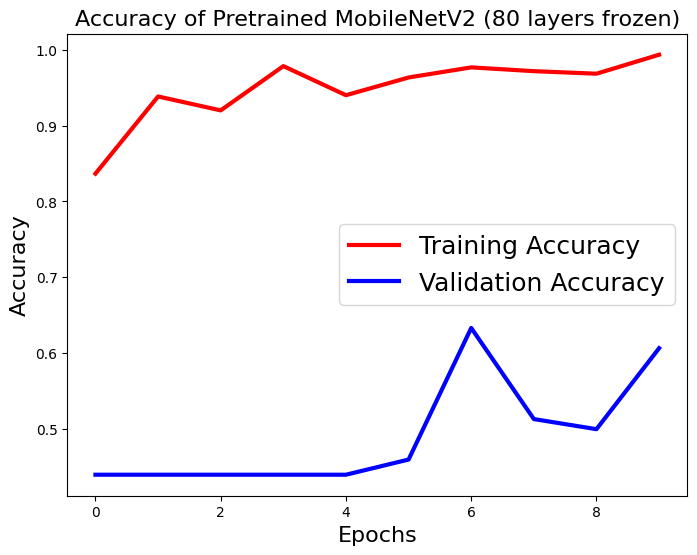

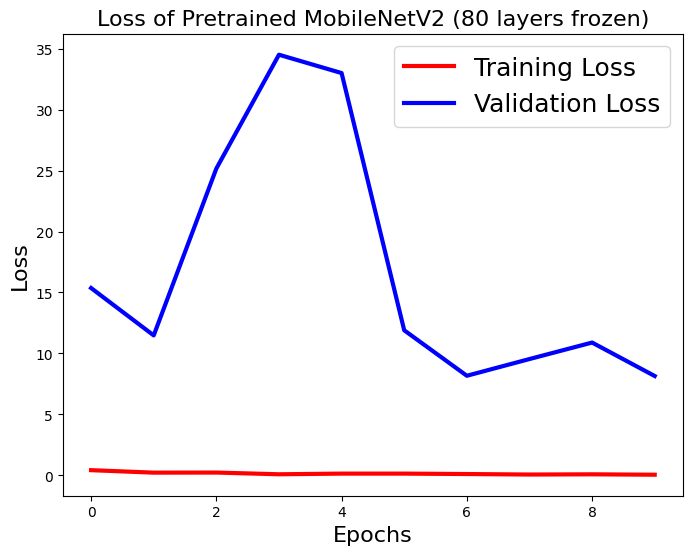

In [8]:
from tensorflow.keras import applications, layers, models

def CNN_App(pretrained=True, input_shape=(64, 64, 3), model_name="MobileNetV2", freeze_layers=0):
    """
    Returns MobileNetV2 Keras Model with optional layer freezing
    Args:
        pretrained (Bool): Whether get a pretrained model or not
        input_shape (Tuple): To create the input layer, should match the image resolution
        model_name (str): String to capture the model name
        freeze_layers (int): Number of layers to freeze from the beginning (0 = no freezing)
    Examples:
        CNN_App(True, freeze_layers=5) -> Model, "Pretrained MobileNetV2 (5 layers frozen)"
    """
    # Load base model
    if pretrained:
        base_model = applications.mobilenet_v2.MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape,
            pooling='avg'
        )
        model_label = f"Pretrained {model_name}"
    else:
        base_model = applications.mobilenet_v2.MobileNetV2(
            weights=None,
            include_top=False,
            input_shape=input_shape,
            pooling='avg'
        )
        model_label = f"Untrained {model_name}"

    # Freeze layers if specified
    if freeze_layers > 0:
        for layer in base_model.layers[:freeze_layers]:
            layer.trainable = False
        model_label += f" ({freeze_layers} layers frozen)"

    # Add classification head
    model = models.Sequential([
        base_model,
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    return model, model_label


# ==================== MobileNetV2 EXPERIMENTS ====================

print("=" * 60)
print("MobileNetV2 EXPERIMENTS")
print("=" * 60)

# 4.1) MobileNetV2 Untrained
print("\n4.1) Training MobileNetV2 Untrained...")
model_41, name_41 = CNN_App(pretrained=False, input_shape=(64, 64, 3), model_name="MobileNetV2")
model_41.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_41 = model_41.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
test_loss_41, test_acc_41 = model_41.evaluate(test_x, test_y)
print(f"{name_41} - Test Accuracy: {test_acc_41:.4f}")
plot_accuracy(history_41, name_41)
plot_loss(history_41, name_41)

# 4.2) MobileNetV2 Pre-trained
print("\n4.2) Training MobileNetV2 Pre-trained...")
model_42, name_42 = CNN_App(pretrained=True, input_shape=(64, 64, 3), model_name="MobileNetV2")
model_42.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_42 = model_42.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
test_loss_42, test_acc_42 = model_42.evaluate(test_x, test_y)
print(f"{name_42} - Test Accuracy: {test_acc_42:.4f}")
plot_accuracy(history_42, name_42)
plot_loss(history_42, name_42)

# 4.3) MobileNetV2 Pre-trained + freezing (5 layers)
print("\n4.3) Training MobileNetV2 Pre-trained with 5 layers frozen...")
model_43, name_43 = CNN_App(pretrained=True, input_shape=(64, 64, 3), model_name="MobileNetV2", freeze_layers=5)
model_43.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_43 = model_43.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
test_loss_43, test_acc_43 = model_43.evaluate(test_x, test_y)
print(f"{name_43} - Test Accuracy: {test_acc_43:.4f}")
plot_accuracy(history_43, name_43)
plot_loss(history_43, name_43)

# 4.4) MobileNetV2 Pre-trained + freezing (30 layers)
print("\n4.4) Training MobileNetV2 Pre-trained with 30 layers frozen...")
model_44, name_44 = CNN_App(pretrained=True, input_shape=(64, 64, 3), model_name="MobileNetV2", freeze_layers=30)
model_44.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_44 = model_44.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
test_loss_44, test_acc_44 = model_44.evaluate(test_x, test_y)
print(f"{name_44} - Test Accuracy: {test_acc_44:.4f}")
plot_accuracy(history_44, name_44)
plot_loss(history_44, name_44)

# 4.5) MobileNetV2 Pre-trained + freezing (80 layers)
print("\n4.5) Training MobileNetV2 Pre-trained with 80 layers frozen...")
model_45, name_45 = CNN_App(pretrained=True, input_shape=(64, 64, 3), model_name="MobileNetV2", freeze_layers=80)
model_45.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_45 = model_45.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(test_x, test_y))
test_loss_45, test_acc_45 = model_45.evaluate(test_x, test_y)
print(f"{name_45} - Test Accuracy: {test_acc_45:.4f}")
plot_accuracy(history_45, name_45)
plot_loss(history_45, name_45)


# ==================== SUMMARY OF MobileNetV2 EXPERIMENTS ====================

print("\n" + "=" * 60)
print("SUMMARY OF MobileNetV2 EXPERIMENTS")
print("=" * 60)

mobilenet_results = [
    (name_41, test_acc_41),
    (name_42, test_acc_42),
    (name_43, test_acc_43),
    (name_44, test_acc_44),
    (name_45, test_acc_45),
]

for i, (name, acc) in enumerate(mobilenet_results, start=1):
    print(f"4.{i}) {name}: {acc:.4f}")

### 2.2.9 Layers Freezing

The following utility method is used for layers freezing.

**TODO**: *Experiment all the pretrained models with layers freezing using* **different number of frozen layers**.

**NOTE**: You will not change this method at all, the experimenting will take place in the test cases section below.

In [11]:
def freeze(model, number_of_frozen_layers):
    layers = model.layers

    layers = layers[:number_of_frozen_layers]

    for layer in layers:
        layer.trainable = False

    return model

### 2.2.10 Make your models

You can use the following utility method to make the model you desire, **modify it if you please**.

In [12]:
def make_model(pretrained=True, freeze_layers=False, number_of_frozen_layers=0, model_selection="VGG"):
    """
    Use this method to create models
    Args:
      pretrained (Bool): Whether make the model pretrained or not, doesn't apply to custom CNN.
      freeze_layers (Bool): Whether apply layers freezing on pretrained networks or not.
      number_of_frozen_layers (int): Number of frozen layers.
      model_selection (Str): Must be exactly "Custom", or "VGG", or "ResNet" or anything else for CNN_App
    """
    # ==================================================================== TAKE CARE ==========================================================================
    # You might need to make the input shape an additional parameter to the function instead of being statically defined here
    # This will help you configure the input_shape when you handle the error due to the vanishing input dimensions in very deep networks like inception_resnetV2
    input_shape = (64, 64, 3)

    if model_selection == "Custom":
        model, model_name = CustomCNN(input_shape)
    elif model_selection == "VGG":
        model, model_name = VGG(pretrained, input_shape)
    elif model_selection == "ResNet":
        model, model_name = ResNet(pretrained, input_shape)
    else:
        model, model_name = CNN_App(pretrained, input_shape)

    if model_selection != "Custom":
        if freeze_layers:
            model = freeze(model, number_of_frozen_layers)
            model_name = model_name + " with " + str(number_of_frozen_layers) + " Frozen Layers"

        ## Add classification head for non custom models
        y = model.output
        y = Flatten()(y)
        y = Dense(256, activation='relu')(y)
        y = Dense(1, activation='sigmoid', name='fc')(y)

        model = Model(inputs=model.input, outputs=y)

    return model, model_name

### 2.2.11 Testing model utility method

This is a generic method that will be used to test all the implemented models, a modular design allows you to experiment more clearly. **Modify it if you please.**

**TODO**:

1. Try different [optimizers](https://keras.io/api/optimizers/) and report their affect on the **results** and plots.
2. For each optimizer, try different learning rates and other hyperparameters (If applicable), and report the difference on the **results** and plots.
3. Try different [loss functions](https://keras.io/api/losses/), and report their affect on **accuracy** and plots.

**IMPORTANT NOTE**: You don't need to try different optimizers, learning rates and hyperparameters, and losses on all models, **just find the best model with the current optimizers, rates and hyperparameters & losses** **then try your experiments** (changing optimizers, rates and hyperparameters & losses) only on this best model.

***The best model is obtained after testing the different models defined above in different cases (untrained, pretrained without freezing, and pretrained with different number of frozen layers) and choosing the model case giving the best performance***

**Make sure to add the following to the report:**


*   The best model found and its accuracy before tuning (5.1 in the report)
*   Include the default case for the optimizer and its hyperparameters using SGD(lr=0.0001, momentum=0.9, nesterov=True) (5.2 in the report)
*   Experiment with other combinations of optimizers and their hyperparameters (5.3, 5.4, 5.5, 5.6 in the report)
*   Include the default case for the loss using Binary Crossentropy (5.7 in the report)
*   Try out two other loss functions (5.8, 5.9 in the report)


In [13]:
# Resize images for InceptionResNetV2
print("Resizing images for InceptionResNetV2...")
train_x_resized, train_y_resized, test_x_resized, test_y_resized = preprocess_data_resized(
    train_x, train_y, test_x, test_y, target_size=(128, 128)
)

Resizing images for InceptionResNetV2...



3.12) Training InceptionResNetV2 Pre-trained...
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.6822 - loss: 0.5794 - val_accuracy: 0.4400 - val_loss: 64.8162
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.9371 - loss: 0.2353 - val_accuracy: 0.6000 - val_loss: 6.2779
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.9769 - loss: 0.1210 - val_accuracy: 0.5600 - val_loss: 2.4082
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.9966 - loss: 0.0278 - val_accuracy: 0.4533 - val_loss: 1.4914
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.9998 - loss: 0.0036 - val_accuracy: 0.7467 - val_loss: 0.6054
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.9962 - loss: 0.0123 - val_accuracy: 0.9800 - val_loss: 0.1236
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.9958 - loss: 0.0132 - val_accuracy: 0.9667 - val_loss: 0.1620
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - a

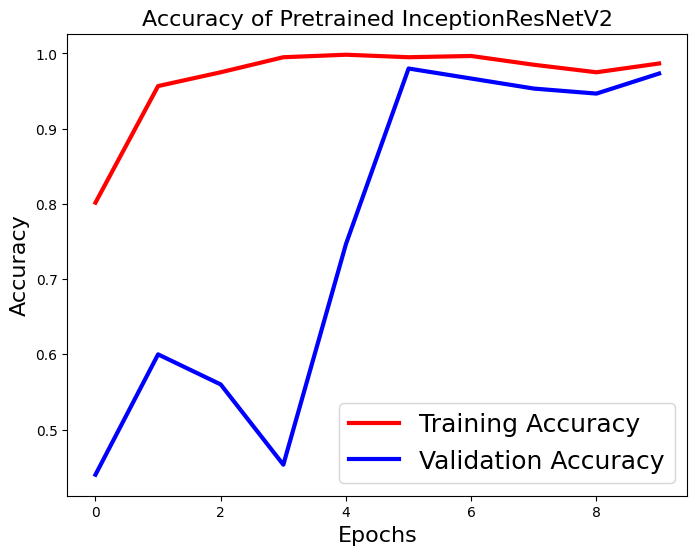

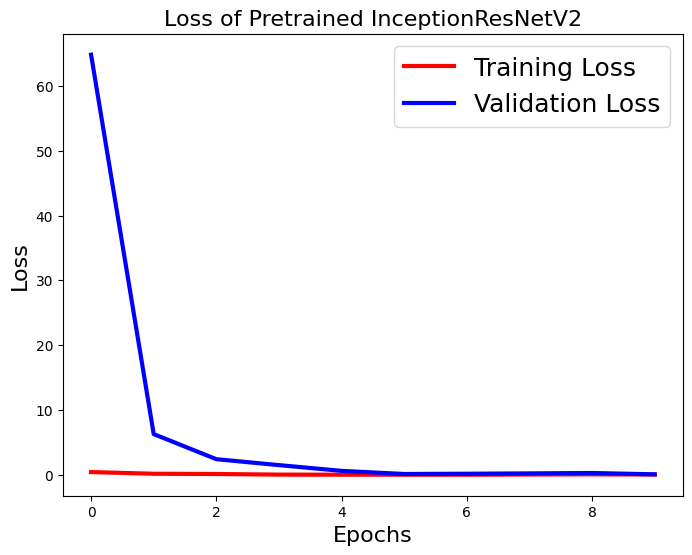

In [25]:
# 3.12) InceptionResNetV2 Pre-trained
print("\n3.12) Training InceptionResNetV2 Pre-trained...")
model_312, name_312 = ResNet(pretrained=True, input_shape=(128, 128, 3), model_name="InceptionResNetV2")
model_312.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_312 = model_312.fit(train_x_resized, train_y_resized, batch_size=32, epochs=10, validation_data=(test_x_resized, test_y_resized))
test_loss_312, test_acc_312 = model_312.evaluate(test_x_resized, test_y_resized)
print(f"{name_312} - Test Accuracy: {test_acc_312:.4f}")
plot_accuracy(history_312, name_312)
plot_loss(history_312, name_312)


5.1) Testing Best Model - InceptionResNetV2 Pretrained (Baseline)
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.4981 - loss: 0.7457 - val_accuracy: 0.4733 - val_loss: 0.8292
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.7767 - loss: 0.5429 - val_accuracy: 0.5267 - val_loss: 0.7032
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.8923 - loss: 0.4071 - val_accuracy: 0.7067 - val_loss: 0.5999
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.9334 - loss: 0.2900 - val_accuracy: 0.6933 - val_loss: 0.5962
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.9664 - loss: 0.1933 - val_accuracy: 0.7467 - val_loss: 0.5683
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.9748 - loss: 0.1421 - val_accuracy: 0.7533 - val_loss: 0.5222
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.9840 - loss: 0.0974 - val_accuracy: 0.8000 - val_loss: 0.4421
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 

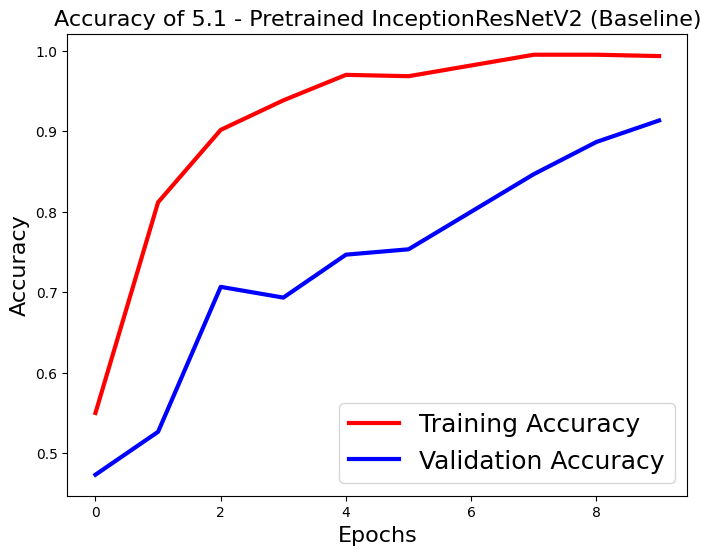

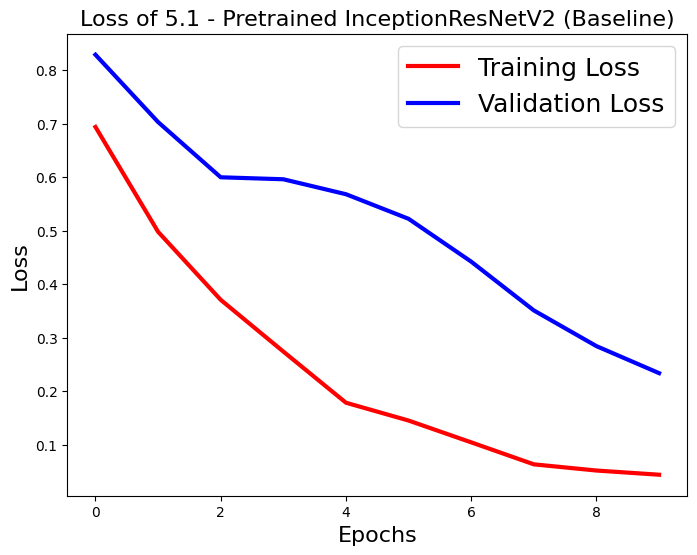

In [16]:

# 5.1) Best Model Baseline - InceptionResNetV2 Pre-trained with SGD
print("\n5.1) Testing Best Model - InceptionResNetV2 Pretrained (Baseline)")
model_51, name_51 = ResNet(pretrained=True, input_shape=(128, 128, 3), model_name="InceptionResNetV2")

# Compile with SGD optimizer (default settings)
from tensorflow.keras.optimizers import SGD
sgd = SGD(learning_rate=0.001, momentum=0.8, nesterov=True)
model_51.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_51 = model_51.fit(train_x_resized, train_y_resized, batch_size=32, epochs=10, validation_data=(test_x_resized, test_y_resized))

# Evaluate
test_loss_51, test_acc_51 = model_51.evaluate(test_x_resized, test_y_resized)
print(f"5.1 - {name_51} (Baseline) - Test Accuracy: {test_acc_51:.4f}")

# Plot results
plot_accuracy(history_51, f"5.1 - {name_51} (Baseline)")
plot_loss(history_51, f"5.1 - {name_51} (Baseline)")


5.2) Testing Optimizer - Adam
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - accuracy: 0.6386 - loss: 0.6255 - val_accuracy: 0.6333 - val_loss: 0.6293
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.9296 - loss: 0.2655 - val_accuracy: 0.7733 - val_loss: 0.4603
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9836 - loss: 0.0770 - val_accuracy: 0.9267 - val_loss: 0.3203
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.9836 - loss: 0.0556 - val_accuracy: 0.9533 - val_loss: 0.2336
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.9959 - loss: 0.0217 - val_accuracy: 0.9533 - val_loss: 0.1700
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.9992 - loss: 0.0095 - val_accuracy: 0.9667 - val_loss: 0.1365
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9995 - loss: 0.0110 - val_accuracy: 0.9667 - val_loss: 0.1010
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 1.0000 - l

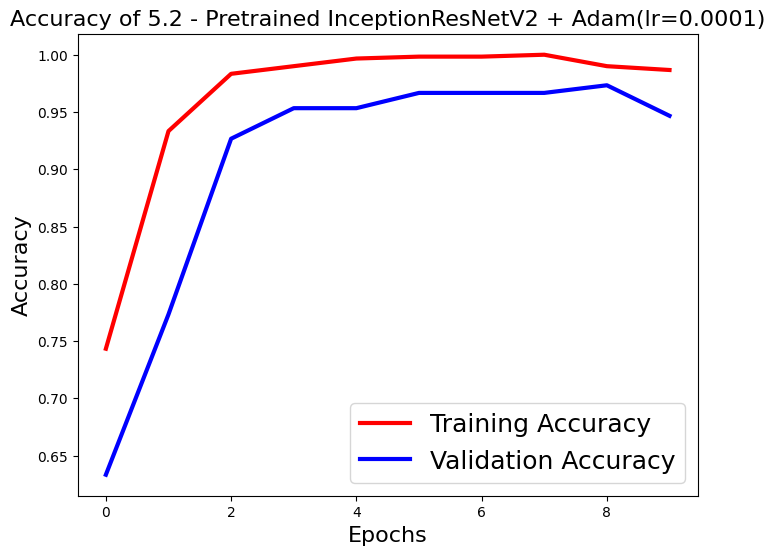

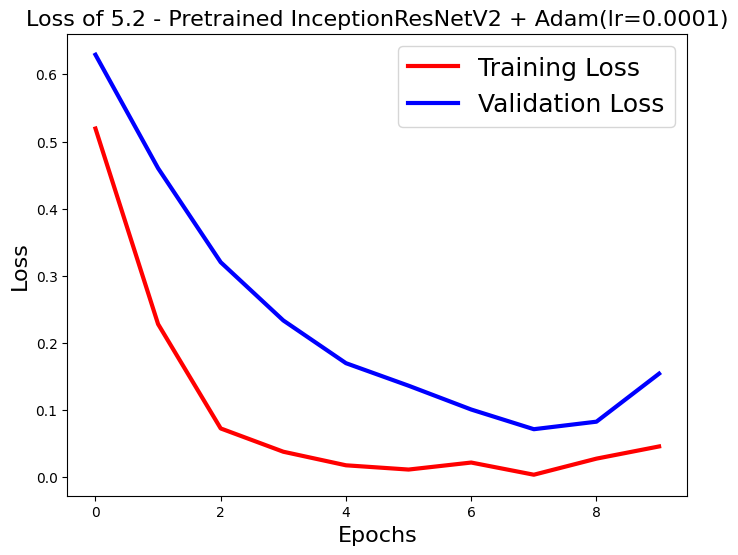

In [17]:
# 5.2) Adam optimizer
print("\n5.2) Testing Optimizer - Adam")
model_52, name_52 = ResNet(pretrained=True, input_shape=(128, 128, 3), model_name="InceptionResNetV2")

# Compile with Adam optimizer
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)
model_52.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_52 = model_52.fit(train_x_resized, train_y_resized, batch_size=32, epochs=10, validation_data=(test_x_resized, test_y_resized))

# Evaluate
test_loss_52, test_acc_52 = model_52.evaluate(test_x_resized, test_y_resized)
print(f"5.2 - {name_52} + Adam(lr=0.0001) - Test Accuracy: {test_acc_52:.4f}")

# Plot results
plot_accuracy(history_52, f"5.2 - {name_52} + Adam(lr=0.0001)")
plot_loss(history_52, f"5.2 - {name_52} + Adam(lr=0.0001)")


5.3) Testing Optimizer - RMSprop
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.6676 - loss: 0.5933 - val_accuracy: 0.4600 - val_loss: 1.0559
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.9274 - loss: 0.2009 - val_accuracy: 0.5000 - val_loss: 0.8237
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.9715 - loss: 0.0998 - val_accuracy: 0.6267 - val_loss: 0.5763
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9894 - loss: 0.0397 - val_accuracy: 0.8133 - val_loss: 0.4199
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.9979 - loss: 0.0133 - val_accuracy: 0.8400 - val_loss: 0.3537
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.8733 - val_loss: 0.2986
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.9995 - loss: 0.0040 - val_accuracy: 0.9200 - val_loss: 0.2414
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 1.0000 

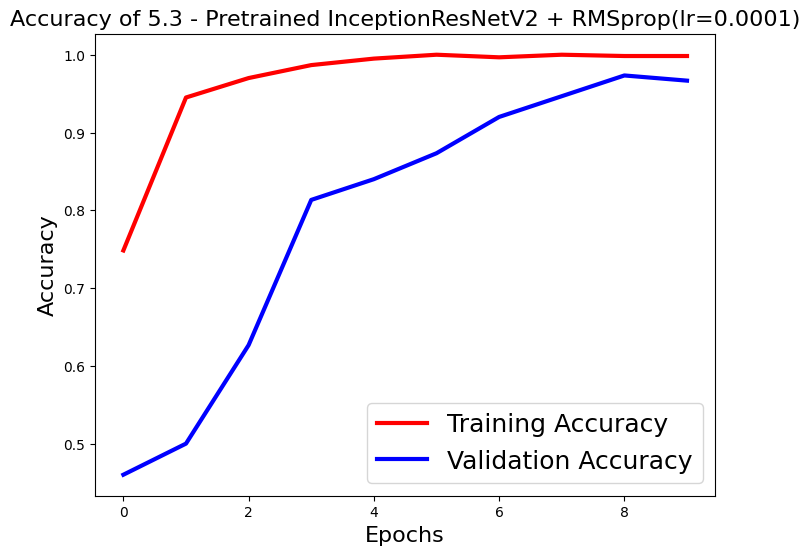

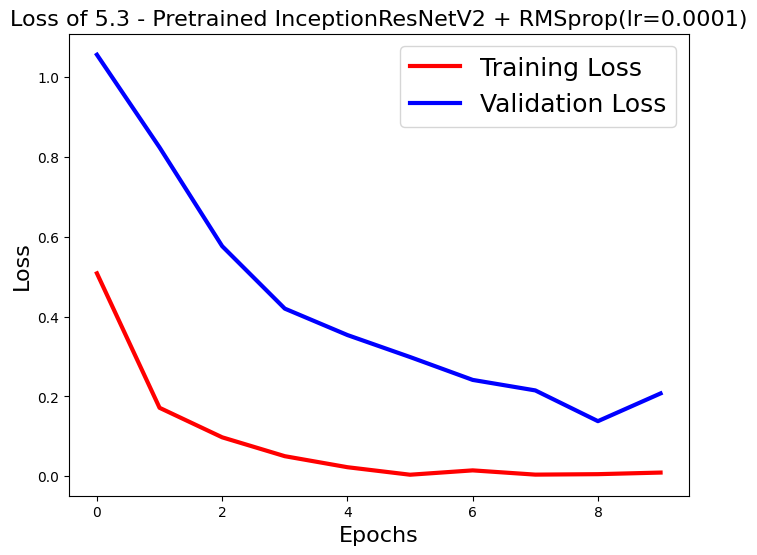

In [18]:
# 5.3) RMSprop optimizer
print("\n5.3) Testing Optimizer - RMSprop")
model_53, name_53 = ResNet(pretrained=True, input_shape=(128, 128, 3), model_name="InceptionResNetV2")

# Compile with RMSprop optimizer
from tensorflow.keras.optimizers import RMSprop
rmsprop = RMSprop(learning_rate=0.0001)
model_53.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_53 = model_53.fit(train_x_resized, train_y_resized, batch_size=32, epochs=10, validation_data=(test_x_resized, test_y_resized))

# Evaluate
test_loss_53, test_acc_53 = model_53.evaluate(test_x_resized, test_y_resized)
print(f"5.3 - {name_53} + RMSprop(lr=0.0001) - Test Accuracy: {test_acc_53:.4f}")

# Plot results
plot_accuracy(history_53, f"5.3 - {name_53} + RMSprop(lr=0.0001)")
plot_loss(history_53, f"5.3 - {name_53} + RMSprop(lr=0.0001)")


5.4) Testing Optimizer - Adamax
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 241s 5s/step - accuracy: 0.5646 - loss: 0.6821 - val_accuracy: 0.6467 - val_loss: 0.6386
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - accuracy: 0.9015 - loss: 0.3507 - val_accuracy: 0.7333 - val_loss: 0.5798
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.9617 - loss: 0.2138 - val_accuracy: 0.7667 - val_loss: 0.5580
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.9850 - loss: 0.1046 - val_accuracy: 0.6733 - val_loss: 0.5763
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.9852 - loss: 0.0673 - val_accuracy: 0.6933 - val_loss: 0.5543
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.9870 - loss: 0.0649 - val_accuracy: 0.7600 - val_loss: 0.4946
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.9992 - loss: 0.0263 - val_accuracy: 0.7933 - val_loss: 0.4364
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.9963 -

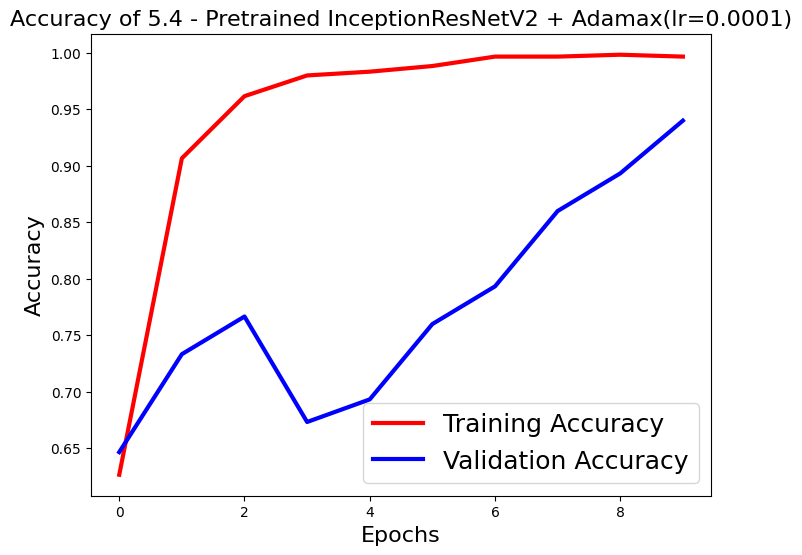

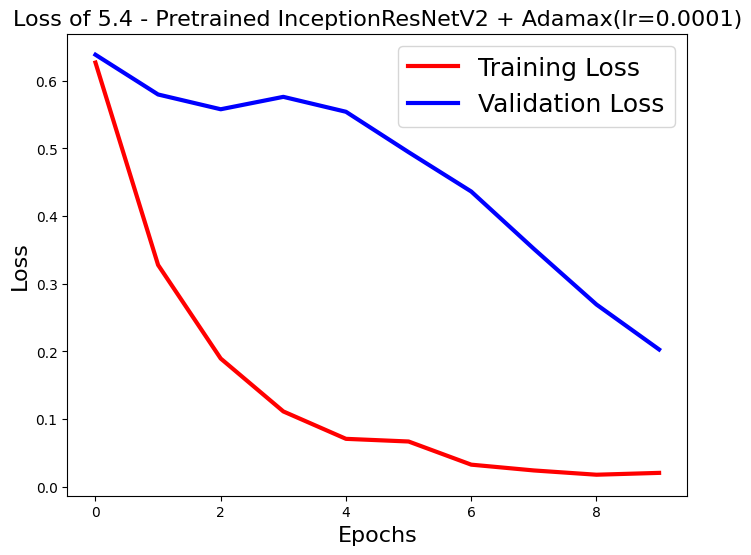

In [14]:
# 5.4) Adamax optimizer
print("\n5.4) Testing Optimizer - Adamax")
model_54, name_54 = ResNet(pretrained=True, input_shape=(128, 128, 3), model_name="InceptionResNetV2")

# Compile with Adamax optimizer
from tensorflow.keras.optimizers import Adamax
adamax = Adamax(learning_rate=0.0001)
model_54.compile(optimizer=adamax, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_54 = model_54.fit(train_x_resized, train_y_resized, batch_size=32, epochs=10, validation_data=(test_x_resized, test_y_resized))

# Evaluate
test_loss_54, test_acc_54 = model_54.evaluate(test_x_resized, test_y_resized)
print(f"5.4 - {name_54} + Adamax(lr=0.0001) - Test Accuracy: {test_acc_54:.4f}")

# Plot results
plot_accuracy(history_54, f"5.4 - {name_54} + Adamax(lr=0.0001)")
plot_loss(history_54, f"5.4 - {name_54} + Adamax(lr=0.0001)")


5.5) Testing Loss Function - Hinge Loss with RMSprop
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 183s 4s/step - accuracy: 0.6724 - loss: 0.8790 - val_accuracy: 0.7267 - val_loss: 0.8485
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.9611 - loss: 0.5835 - val_accuracy: 0.8067 - val_loss: 0.7480
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9899 - loss: 0.5103 - val_accuracy: 0.8067 - val_loss: 0.7048
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9977 - loss: 0.5403 - val_accuracy: 0.8533 - val_loss: 0.6405
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.9926 - loss: 0.4980 - val_accuracy: 0.8667 - val_loss: 0.6215
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.9992 - loss: 0.5084 - val_accuracy: 0.8933 - val_loss: 0.5712
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.9988 - loss: 0.5142 - val_accuracy: 0.9333 - val_loss: 0.5240
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step

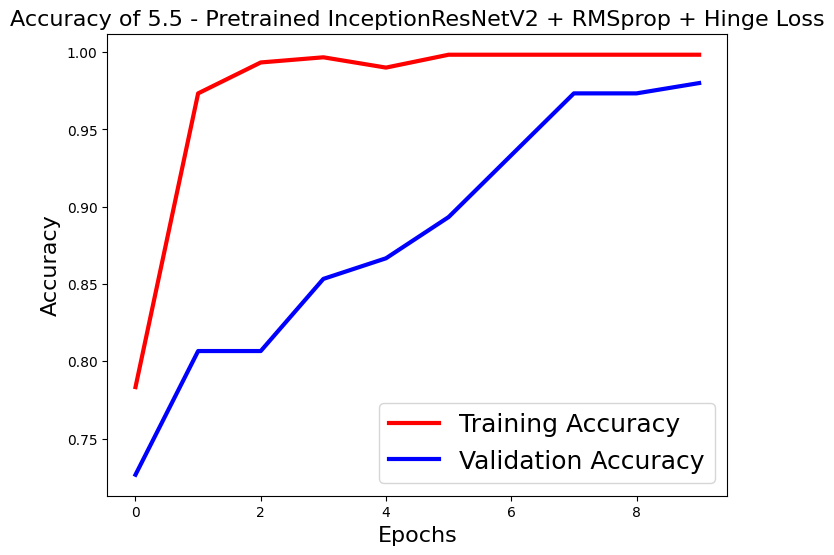

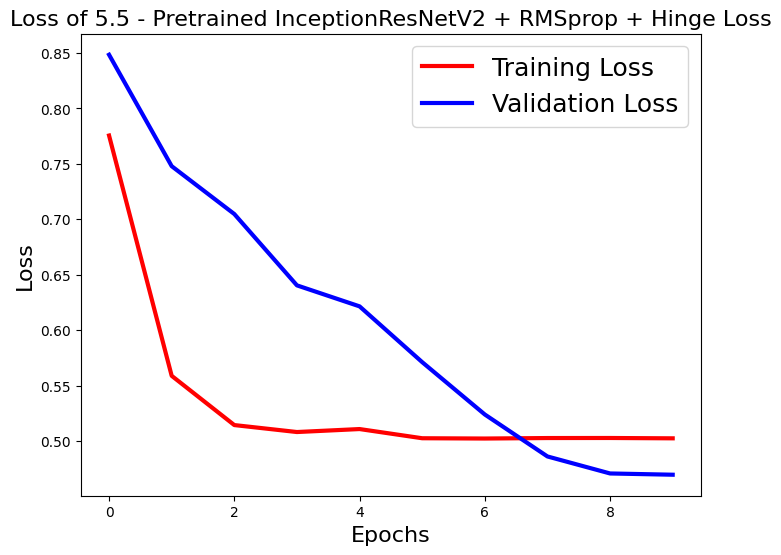

In [15]:
# 5.5) RMSprop optimizer with Hinge loss
print("\n5.5) Testing Loss Function - Hinge Loss with RMSprop")
model_55, name_55 = ResNet(pretrained=True, input_shape=(128, 128, 3), model_name="InceptionResNetV2")

# Compile with RMSprop optimizer and Hinge loss
from tensorflow.keras.optimizers import RMSprop
rmsprop = RMSprop(learning_rate=0.0001)
model_55.compile(optimizer=rmsprop, loss='hinge', metrics=['accuracy'])

# Train the model
history_55 = model_55.fit(train_x_resized, train_y_resized, batch_size=32, epochs=10, validation_data=(test_x_resized, test_y_resized))

# Evaluate
test_loss_55, test_acc_55 = model_55.evaluate(test_x_resized, test_y_resized)
print(f"5.5 - {name_55} + RMSprop + Hinge Loss - Test Accuracy: {test_acc_55:.4f}")

# Plot results
plot_accuracy(history_55, f"5.5 - {name_55} + RMSprop + Hinge Loss")
plot_loss(history_55, f"5.5 - {name_55} + RMSprop + Hinge Loss")


5.6) Testing Loss Function - Binary Focal Crossentropy with RMSprop
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 196s 4s/step - accuracy: 0.6963 - loss: 0.1487 - val_accuracy: 0.5800 - val_loss: 0.3016
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.9649 - loss: 0.0364 - val_accuracy: 0.6267 - val_loss: 0.1968
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.9792 - loss: 0.0164 - val_accuracy: 0.5733 - val_loss: 0.4774
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9748 - loss: 0.0218 - val_accuracy: 0.7933 - val_loss: 0.1468
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.9849 - loss: 0.0102 - val_accuracy: 0.8933 - val_loss: 0.0631
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.9867 - loss: 0.0171 - val_accuracy: 0.8933 - val_loss: 0.0965
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.9931 - loss: 0.0078 - val_accuracy: 0.9467 - val_loss: 0.0450
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━

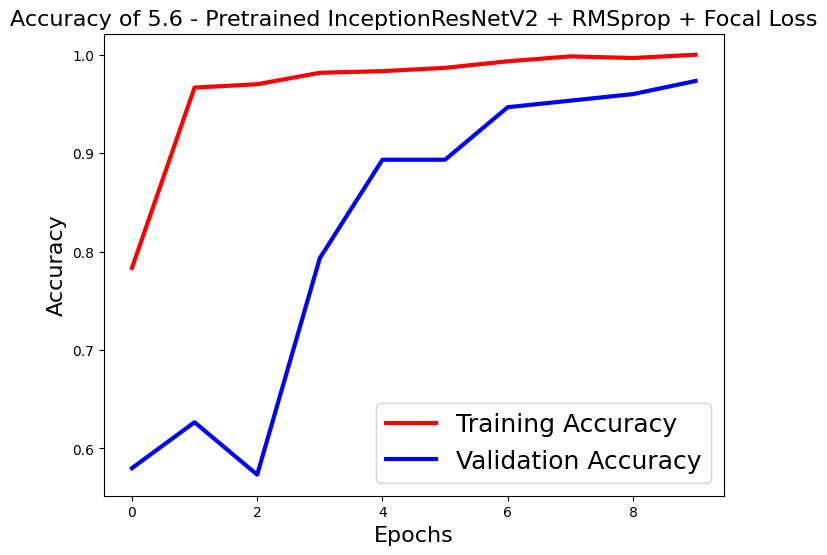

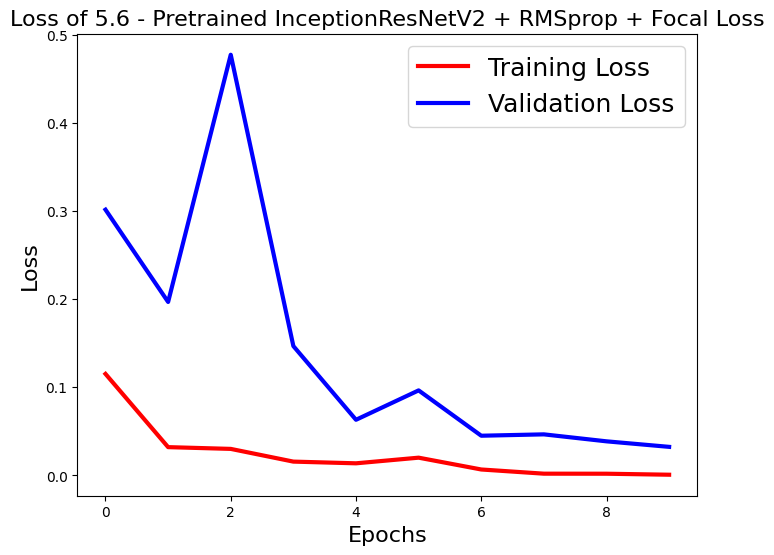

In [16]:
# 5.6) RMSprop optimizer with Binary Focal Crossentropy loss
print("\n5.6) Testing Loss Function - Binary Focal Crossentropy with RMSprop")
model_56, name_56 = ResNet(pretrained=True, input_shape=(128, 128, 3), model_name="InceptionResNetV2")

# Compile with RMSprop optimizer and Binary Focal Crossentropy loss
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryFocalCrossentropy
rmsprop = RMSprop(learning_rate=0.0001)
focal_loss = BinaryFocalCrossentropy(gamma=2.0, from_logits=False)
model_56.compile(optimizer=rmsprop, loss=focal_loss, metrics=['accuracy'])

# Train the model
history_56 = model_56.fit(train_x_resized, train_y_resized, batch_size=32, epochs=10, validation_data=(test_x_resized, test_y_resized))

# Evaluate
test_loss_56, test_acc_56 = model_56.evaluate(test_x_resized, test_y_resized)
print(f"5.6 - {name_56} + RMSprop + Focal Loss - Test Accuracy: {test_acc_56:.4f}")

# Plot results
plot_accuracy(history_56, f"5.6 - {name_56} + RMSprop + Focal Loss")
plot_loss(history_56, f"5.6 - {name_56} + RMSprop + Focal Loss")

In [ ]:
def test_model(model, model_name, epochs=10, print_summary=True, plot_results=True):
    '''TODO: Experiment with different optimizers, learning rates and hyperparameters, and losses on the best model'''

    sgd = SGD(lr=0.0001, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

    if (print_summary):
        model.summary()

    hist = model.fit(train_x, train_y, validation_data = (test_x, test_y), verbose=1, epochs=epochs, batch_size=32)
    preds = model.evaluate(test_x, test_y, batch_size=32, verbose=1, sample_weight=None)

    print ("Validation Loss = " + str(preds[0]))
    print ("Validation Accuracy = " + str(preds[1]))

    if(plot_results):
        plot_loss(hist, model_name)
        plot_accuracy(hist, model_name)

### 2.2.12 Create your model test cases.

**TODO**: Fill here all the test cases methods that you want to apply.

Add methods (Untrained, pretrained & pretrained with freezing) for *(at least)*:
1. ResNet()
2. CNN_App()

**NOTE**: *Those test cases, don't change use case types (i.e. you will need to change the VGG in VGG() method to VGG19 and re test again or make another function for VGG19 for example) and doesn't change the loss function nor the optimizer type (these need to be changed in the testing utility method).*


In [ ]:
def test_custom_CNN(epochs=20, print_summary=True, plot_results=True):
    model, model_name = make_model(False, False, 0, "Custom")
    test_model(model, model_name, epochs, print_summary, plot_results)

In [ ]:
def test_untrained_VGG(epochs=20, print_summary=True, plot_results=True):
    model, model_name = make_model(False, False, 0, "VGG")
    test_model(model, model_name, epochs, print_summary, plot_results)

In [ ]:
def test_pretrained_VGG(epochs=20, print_summary=True, plot_results=True):
    model, model_name = make_model(True, False, 0, "VGG")
    test_model(model, model_name, epochs, print_summary, plot_results)

In [ ]:
def test_pretrained_layers_freezing_VGG(epochs=20, print_summary=True, plot_results=True):
    model, model_name = make_model(True, True, 5, "VGG")
    test_model(model, model_name, epochs, print_summary, plot_results)

###  2.2.13 Test your models

**TODO**: Call all your defined methods for testing here.

**Note**: You might want to go up to **1000** epochs for the untrained model if the validation accuracy is low.

In [ ]:
test_custom_CNN(20)

In [ ]:
test_untrained_VGG(100)

In [ ]:
test_pretrained_VGG(20)

In [ ]:
test_pretrained_layers_freezing_VGG(20)

## 2.3 Conclusion

That's it! Congratulations on training CNN use cases models.

Make sure you deliver all the requirements for the submission.